# Results, section 1:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, get_cmap

In [3]:
train_test_str = 'squeakycleanExclude' # 'squeakycleanExclude' 'trte_psychopathology'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 125 400
primary_covariate = 'ageAtScan1_Years'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale)

In [4]:
os.environ['MODELDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400_streamlineCount'

## Load data pre-nispat data

In [5]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True); print(df_test.shape)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat([df_train, df_test])
df_node = pd.concat([df_node_train, df_node_test])

(317, 21)
(783, 21)


## Age effects

In [6]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
if parc_str == 'lausanne':
    df_age_effect.drop(my_list, axis = 0, inplace = True)
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [7]:
age_filter.sum()

1012

## Load nispat outputs

In [8]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

ys2_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/ys2.txt'), delimiter = ' ').transpose()
df_ys2_forward = pd.DataFrame(data = ys2_forward, index = synth_cov_test.index, columns = df_node.columns)

In [9]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [10]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [11]:
smse_filter.sum()

1023

In [12]:
df_yhat_forward_tmp = df_yhat_forward + (df_yhat_forward.abs().max()+1)
print((df_yhat_forward_tmp<0).any().any())

annualized = True
if annualized:
    elapsed_time = synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[-1] - synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[0]
    print(elapsed_time)
    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1
    df_yhat_tmp1 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp1[x<0] = df_yhat_tmp1[x<0]*-1

    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1
    df_yhat_tmp2 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp2[x<0] = df_yhat_tmp2[x<0]*-1
else:
    df_yhat_tmp1 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1) * 100
    df_yhat_tmp2 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1) * 100

df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)
df_yhat_diff.head()

False
14.0


,0,1
ct_0,-1.326431,-1.305994
ct_1,-1.954306,-1.981008
ct_2,-1.715613,-1.728359
ct_3,-2.422433,-2.449050
ct_4,-0.222513,-0.208736


# Plots

In [13]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

metrics = ('ct', 'str', 'ac', 'mc')
metrics_label_short = ('Thickness', 'Strength', 'Ave. ctrb.', 'Mod. ctrb.')
metrics_label = ('Thickness', 'Strength', 'Average controllability', 'Modal controllability')
print(metrics)

('ct', 'str', 'ac', 'mc')


## Brain plots nispat

In [14]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [15]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

In [16]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0 = Male, 1 = Female

In [17]:
for metric in metrics:
    for hemi in ('lh', 'rh'):
        for sx in ('sex0','sex1'):
            # Plots of age correlation
            fig_str = hemi + '_' + metric + '_age_' + sx + '_frwd'
            if sx == 'sex0':
                roi_data = df_yhat_diff.loc[:,0].filter(regex = metric, axis = 0).values
            elif sx == 'sex1':
                roi_data = df_yhat_diff.loc[:,1].filter(regex = metric, axis = 0).values
            age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
            smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
            smse_filt = smse_filt.reshape(-1)
            region_filt = np.logical_and(age_filt,smse_filt)

            roi_data[~region_filt] = -1000
            if metric == 'ct':
                center_anchor = 3
            if metric == 'str':
                center_anchor = 30
            elif metric == 'ac':
                center_anchor = 4
            elif metric == 'mc':
                center_anchor = 1

            if region_filt.any():
                if subject_id == 'lausanne125':
                    parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
                elif subject_id == 'fsaverage':
                    parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NeuroDev_NetworkControl/figs/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                             hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

                if subject_id == 'lausanne125' and metric == 'ct':
                    brain_plot(roi_data, parcel_names[parcel_loc == 1], parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'coolwarm', center_anchor = center_anchor)
                else:
                    brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'coolwarm', center_anchor = center_anchor)
            else:
                print('Nothing significant')

3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
30
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+01, 3.00e+01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+01, 3.00e+01] (opaque)
30
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+01, 3.00e+01] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+01, 3.00e+01] (opaque)
30
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+01, 3

# Figures

In [18]:
%matplotlib inline

Figure 2C (top)

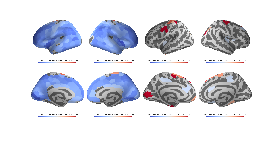

In [19]:
# Age effects
f, axes = plt.subplots(2, 4)
# f.suptitle('age')
f.set_figwidth(4)
f.set_figheight(2)
plt.subplots_adjust(wspace=0, hspace=0)

my_str = '_sex1_frwd'
# column 0:
fig_str = 'lh_ct_age'+my_str+'.png'
try:
#     axes[0,0].set_title('Thickness (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'rh_ct_age'+my_str+'.png'
try:
#     axes[0,1].set_title('Thickness (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')
    
# column 2:
fig_str = 'lh_str_age'+my_str+'.png'
try:
#     axes[0,2].set_title('Ave. ctrb. (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')
    
# column 3:
fig_str = 'rh_str_age'+my_str+'.png'
try:
#     axes[0,3].set_title('Ave. ctrb. (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')

plt.show()
f.savefig('brain_age_ct-str'+my_str+'.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)

Figure 2C (bottom)

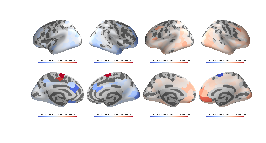

In [20]:
# Age effects
f, axes = plt.subplots(2, 4)
# f.suptitle('age')
f.set_figwidth(4)
f.set_figheight(2)
plt.subplots_adjust(wspace=0, hspace=0)

my_str = '_sex1_frwd'
# column 0:
fig_str = 'lh_ac_age'+my_str+'.png'
try:
#     axes[0,0].set_title('Thickness (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'rh_ac_age'+my_str+'.png'
try:
#     axes[0,1].set_title('Thickness (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')
    
# column 2:
fig_str = 'lh_mc_age'+my_str+'.png'
try:
#     axes[0,2].set_title('Ave. ctrb. (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')
    
# column 3:
fig_str = 'rh_mc_age'+my_str+'.png'
try:
#     axes[0,3].set_title('Ave. ctrb. (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')

plt.show()
f.savefig('brain_age_ac-mc'+my_str+'.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)

eFigure 1A

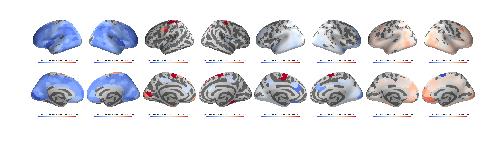

In [21]:
# Age effects
f, axes = plt.subplots(2, 8)
# f.suptitle('age')
f.set_figwidth(8)
f.set_figheight(2)
plt.subplots_adjust(wspace=0, hspace=0)

my_str = '_sex0_frwd'
# column 0:
fig_str = 'lh_ct_age'+my_str+'.png'
try:
#     axes[0,0].set_title('Thickness (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'rh_ct_age'+my_str+'.png'
try:
#     axes[0,1].set_title('Thickness (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')
    
# column 2:
fig_str = 'lh_str_age'+my_str+'.png'
try:
#     axes[0,2].set_title('Degree (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
except FileNotFoundError: axes[0,2].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
except FileNotFoundError: axes[1,2].axis('off')
    
# column 3:
fig_str = 'rh_str_age'+my_str+'.png'
try:
#     axes[0,3].set_title('Degree (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
except FileNotFoundError: axes[0,3].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
except FileNotFoundError: axes[1,3].axis('off')
    
# column 4:
fig_str = 'lh_ac_age'+my_str+'.png'
try:
#     axes[0,4].set_title('Ave. ctrb. (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,4].imshow(image); axes[0,4].axis('off')
except FileNotFoundError: axes[0,4].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,4].imshow(image); axes[1,4].axis('off')
except FileNotFoundError: axes[1,4].axis('off')
    
# column 5:
fig_str = 'rh_ac_age'+my_str+'.png'
try:
#     axes[0,5].set_title('Ave. ctrb. (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,5].imshow(image); axes[0,5].axis('off')
except FileNotFoundError: axes[0,5].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,5].imshow(image); axes[1,5].axis('off')
except FileNotFoundError: axes[1,5].axis('off')
    
# column 6:
fig_str = 'lh_mc_age'+my_str+'.png'
try:
#     axes[0,6].set_title('Mod. ctrb. (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,6].imshow(image); axes[0,6].axis('off')
except FileNotFoundError: axes[0,6].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,6].imshow(image); axes[1,6].axis('off')
except FileNotFoundError: axes[1,6].axis('off')
    
# column 7:
fig_str = 'rh_mc_age'+my_str+'.png'
try:
#     axes[0,7].set_title('Mod. ctrb. (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,7].imshow(image); axes[0,7].axis('off')
except FileNotFoundError: axes[0,7].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,7].imshow(image); axes[1,7].axis('off')
except FileNotFoundError: axes[1,7].axis('off')

plt.show()
f.savefig('brain_age'+my_str+'.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)